In [1]:
%run RSCM_Spatial.py

# crop-specific parameters
cpara = {
    'Tbase'    : 12.0,      # Tbase, base temperature                                     
    'k'        : 0.40,      # Light extinction coefficient                             
    'RUE'      : 2.49,      # Radiation use efficiency                               
    'SLA'      : 0.016,     # Specific leaf area                                     
    'beta1'    : 0.45,      # Ratio of SR to PAR                                   
    'eGDD'     : 30.0,      # GDD at plant emergence                                
    'pd'       : 10         # parameter d (leaf senescence)
}

# ET-associated parameters
ET_para = {
    'a_ndvi'   : 0.60,     # conv. parameter a in NDVI = a * LAI ^ b, rice = 0.60 (Ko et al., 2015)
    'b_ndvi'   : 0.35,     # conv. parameter b in NDVI = a * LAI ^ b, rice = 0.35 (Ko et al., 2015) 
    'd_para1'  : 0.49,     # damping parameter (corr. between LAI & T/ET0), rice = 0.49 (Nay-Htoon et al, 2018)
    'd_para2'  : 0.8,      # damping parameter (corr. between NDVI & LAI), rice = 0.8 (Nay-Htoon et al, 2018)
    'VI_max'   : 1.0,      # max VI or LAI
    'VI_min'   : 0.01,     # min VI or LAI
    'kc_max'   : 1.2,      # max value of crop coefficient (Kc), rice = 1.2 (FAO 56, Allen et al., 1998)
    'ini_D'    : 30,       # init., initial crop development period : rice = 30 (FAO, Allen et al., 1998)
    'dev_D'    : 30,       # Dev., development period : rice = 30
    'mid_D'    : 50,       # mid., mid development period : rice = 80
    'late_D'   : 40,       # late, late development period : rice 40
    'k_ini'    : 1.05,     # initial Kc : rice = 1.05
    'k_mid'    : 1.20,     # mid Kc : rice = 1.20
    'k_end'    : 0.60,     # end Kc : rice = 0.90-60
    'fC_soil'  : 0.29,     # field capacity of the soil water (0.07 ~ 0.40), silt loam = 0.22-0.36
    'wiltPoint': 0.15,     # wilting point of the soil water (0.02 ~ 0.24), silt loam = 0.09-0.21
    'REW'      : 9.5,      # readily evaporated water (2 ~ 12 mm), silt loam = 8-11
    'kc_opt'   : 0,        # basal crop coeff. cal. option: 0 = FAO Kc, 1 =  VI based
    'ke_opt'   : 0,        # soil E parameter cal. option: 0 = using soil info, 1 = using VI
    'kr_opt'   : 1         # E reduction coeff. cal. option: 1 = flooded crops ; 2 >= dryland or irrigated crops
}

# productivity-associated parameters
ppara = {
    'pmGDD' : 775,       # GDD at plant maturity
    'fg1'   : 0.05,     # factor of grain partitioning 1 (0.01-0.05) ### OLD for rice = 10             
    'fg2'   : 0.02,     # factor of grain partitioning 2 (0.01-0.5) ### OLD for rice = 12             
    'a1'    : 0.0064,    # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'b1'    : 0.0097,    # coeff of LUE (LUE_cint = a1 * LAI + b1, Xue et al., 2017)   
    'a2'    : 7.871,     # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)
    'b2'    : 3.781      # coeff of max GPP (GPP_max = a2 * LAI + b2, Xue et al., 2017)  
}

# location parameters
lpara = {
    'lat'   : 34.0,     # Latitude of the site    
    'elev'  : 14,       # Elevation of the site
    'k_Rs'  : 0.11      # Rad adj. coef. (default=0.17,inland=0.16,coast=0.19,Gwangju=0.09)
}

fmLAI    = 10        # factor of max LAI
start    = 148       # start, Start at planting
nrecords = 150       # maximum number of days allowed in simulation since the starting date
  
# Initial guesses of unknown parameters
pa    = 0.1       # parameter a (leaf growth)
pb    = 0.00125   # parameter b (leaf growth)
pc    = 0.00125   # parameter c (leaf senescence)
L0    = 0.02      # parameter L0 (Initial leaf area index)
rGDD  = 750       # parameter rGDD
para0 = np.array((pa, pb, pc, L0, rGDD))

# Under the Bayesian approach, Gaussian priors are applied to the transformed (a,b,c,L0,rGDD)
# Ranges of (a,b,c,L0) are [0,1], so logistic transform is applied
# Range of rGDD is (0,infty), so log transform is applied
prior_mean_tran = para0         # Choose the inversely transformed prior mean
prior_cov = np.diag(1/para0)    # Choose the covariance matrix of the prior


In [2]:
#######################################################################################
# --- Example that estimate the RSCM with Spatial LAI data ---
#######################################################################################

rows = 60
columns = 69
nmaxpixels = 500
nsplits = int(rows*columns/nmaxpixels) 
last_n_pixels = (1*rows*columns) % nmaxpixels
bayOpt = 0

for isplit in range(nsplits + 1):
    if isplit == nsplits:
        npixels = last_n_pixels  
    else:
        npixels = nmaxpixels  
    print(f'Run = {isplit} / {nsplits}')
    data_start = isplit*nmaxpixels   

    # Input the spatial LAI data and weather data and store into 3D arrays.

    sub_paddyFields = read_binary_data('DataSpatial\\FieldInfo\\asia.rice.extent.2010.PJ.dat', np.int16, npixels, data_start).astype(np.int32)
    sub_plantingDate = read_binary_data('DataSpatial\\FieldInfo\\transp.doy.2010.PJ.dat', np.int16, npixels, data_start).astype(np.int32)
    nfiles_lai, index_lai, data_lai_arr = read_binary_data_multiple('DataSpatial\\LAI\\2010','_LAI.bin', np.float32, npixels, data_start)
    nfiles_ssi, index_ssi, data_ssi_arr = read_binary_data_multiple('DataSpatial\\SolarRadiation\\SR.AgERA5.x100.int16.2010','.PJ.dat', np.int16, npixels, data_start)
    nfiles_tmax, index_tmax, data_tmax_arr = read_binary_data_multiple('DataSpatial\\Temperature\\Tmax.AgERA5.x100.int16.2010','.PJ.dat', np.int16, npixels, data_start)
    nfiles_tmin, index_tmin, data_tmin_arr = read_binary_data_multiple('DataSpatial\\Temperature\\Tmin.AgERA5.x100.int16.2010','.PJ.dat', np.int16, npixels, data_start)

    wx_data = np.full((npixels, nfiles_ssi, 4), np.nan)
    obs_d = np.full((npixels, nfiles_lai, 2), np.nan)
    wx_data[:,:,0] = index_ssi
    wx_data[:,:,1] = data_ssi_arr * 0.01
    wx_data[:,:,2] = data_tmax_arr * 0.01
    wx_data[:,:,3] = data_tmin_arr * 0.01

    shrift = 40
    obs_d[:,:,0] = index_lai + shrift
    obs_d[:,:,1] = data_lai_arr
    obs_d = np.where(np.isnan(obs_d),-999,obs_d)

    (paraout,ODOYLAI) = Optim_RSCM_LAI(cpara,fmLAI,nrecords,wx_data,obs_d,sub_paddyFields,sub_plantingDate,para0,bayOpt,prior_cov,prior_mean_tran)
    (cyield,RSCMProcess)=sim_cG(paraout,ODOYLAI,ET_para,ppara,lpara,cpara,sub_plantingDate,wx_data)
    if isplit == 0:
        # Appending the results to the arrays
        RSCMProcess_all = RSCMProcess
        paraout_all = paraout
        cyield_all = cyield
    else:
        # Appending the results to the arrays
        RSCMProcess_all = np.concatenate((RSCMProcess_all, RSCMProcess), axis=0)
        paraout_all = np.concatenate((paraout_all, paraout), axis=0)
        cyield_all = np.append(cyield_all, cyield)


Run = 0 / 8
Run = 1 / 8
Run = 2 / 8
Run = 3 / 8
Run = 4 / 8
Run = 5 / 8
Run = 6 / 8
Run = 7 / 8
Run = 8 / 8


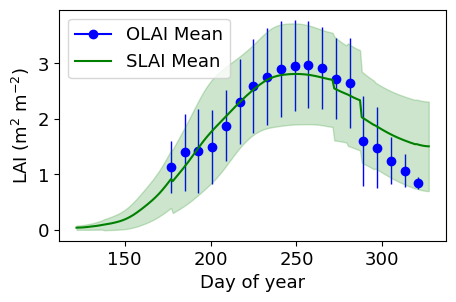

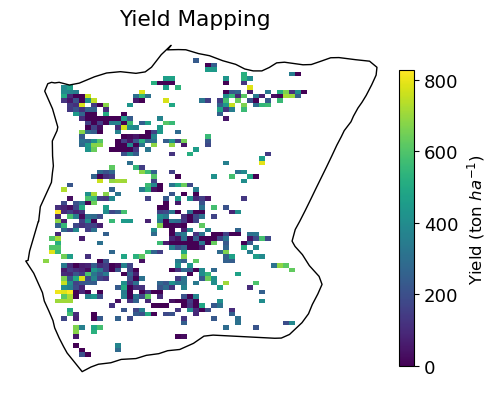

In [3]:
# Save the calculation results of all pixels.
save_out_pixgro('OutputSpatial',RSCMProcess_all, cyield_all,paraout_all)

# Save the summary statistics.
outf = open('OutputSpatial/sim_cGrowth_Summary.out', 'w')
save_out_pixgro_summary(outf, RSCMProcess_all, cyield_all)
outf.close()

# Plot the average growth curve
plot_pixgro_out(RSCMProcess_all, plot_file_path = None)

# Show the predicted yield on the map
map_extent = [126.65, 127, 37.65, 38.0] ## -- [lon_min, lon_max, lat_min, lat_max]
image_extent = [126.67, 127.01, 37.69, 37.98] ## -- [lon_min, lon_max, lat_min, lat_max] 
map_output_path = 'OutputSpatial/yield_map.png'  # saving the map
map_dir = 'DataSpatial\\PajuMap\\Paju.shp'
mapping_yield(map_dir, cyield_all, 60, 69, map_extent, image_extent, map_file_path = None) ### map_output_path)